In [0]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
# from gensim.models import Word2Vec
# from gensim.models import KeyedVectors
import pickle

import os

from collections import Counter
from scipy.sparse import hstack

from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/IRE_Major_Project/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data = pd.read_csv(root_path+'preprocessed.csv')

In [0]:
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_a,subtask_b,subtask_c,new_tweet_length,original_tweet_length
0,86426,@USER She should ask a few native Americans wh...,ask native americans take be,1,0,0,0,OFF,UNT,NaN,5,14
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home drink maga trump2020,3,2,1,1,OFF,TIN,IND,5,11
2,16820,Amazon is investigating Chinese employees who ...,amazon investigate chinese employees sell inte...,0,5,1,0,NOT,NaN,NaN,19,27
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone should vetaken piece shit volcano,1,0,0,1,OFF,UNT,NaN,6,11
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama want liberals amp illegals move red state,2,0,0,0,NOT,NaN,NaN,8,12


Dropping subtask a and b columns

In [0]:
data = data[data['subtask_c'].isin(['IND'  , 'GRP' , 'OTH'])]
data.drop(columns=['subtask_a' , 'subtask_b'] , inplace = True)
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_c,new_tweet_length,original_tweet_length
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home drink maga trump2020,3,2,1,1,IND,5,11
5,97670,@USER Liberals are all Kookoo !!!,liberals kookoo,1,0,0,0,OTH,2,6
7,52415,@USER was literally just talking about this lo...,literally talk lol mass shoot like set up prop...,1,0,0,0,GRP,18,31
9,13384,@USER Canada doesn’t need another CUCK! We alr...,canada not need another cuck already enough lo...,1,4,0,0,IND,15,19
12,28414,@USER you are a lying corrupt traitor!!! Nobod...,lie corrupt traitor nobody want hear anymore l...,1,1,1,0,IND,9,17


In [0]:
data.loc[data['original_tweet_length'].idxmax()]

id                                                                   29558
tweet                    @USER @USER @USER @USER @USER @USER @USER @USE...
new_tweet                even pedophiles interview tell way stop kill t...
user_mentions                                                           50
n_hash_tags                                                              0
n_urls                                                                   0
n_emojis                                                                 0
subtask_c                                                              GRP
new_tweet_length                                                        25
original_tweet_length                                                  101
Name: 2397, dtype: object

In [0]:
data.loc[data['new_tweet_length'].idxmax()]

id                                                                   78296
tweet                    #NoToKavanaugh  He'll REVERSE Roe vs Wade-wome...
new_tweet                notokavanaugh he ll reverse roe vs wade women ...
user_mentions                                                            0
n_hash_tags                                                              1
n_urls                                                                   1
n_emojis                                                                 0
subtask_c                                                              GRP
new_tweet_length                                                        44
original_tweet_length                                                   38
Name: 11784, dtype: object

# Splitting Data: Train and Test


In [0]:
Y = data['subtask_c']
X = data.drop(['subtask_c','id'],axis=1)
print("Shape of X: ",X.shape)
print("Shape of Y: ",Y.shape)

Shape of X:  (3876, 8)
Shape of Y:  (3876,)


In [0]:
data['subtask_c'].value_counts()

IND    2407
GRP    1074
OTH     395
Name: subtask_c, dtype: int64

In [0]:
#separating data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.30,stratify=Y, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ",Y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of Y_test: ",Y_test.shape)

Shape of X_train:  (2713, 8)
Shape of Y_train:  (2713,)
Shape of X_test:  (1163, 8)
Shape of Y_test:  (1163,)


#### Change the mapping of the label column to binary


In [0]:
Y_train = Y_train.map(dict(IND=0, GRP=1 , OTH= 2))
Y_test = Y_test.map(dict(IND=0, GRP=1 , OTH = 2))

In [0]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(X_train.isnull())
#  X_train[X_train.isna().any(axis=1)]

# Convolution Model

In [0]:
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Dropout, Flatten, Lambda, Embedding
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.initializers import RandomNormal
from keras.engine import Layer, InputSpec
from keras import backend as K
K.tensorflow_backend.set_image_dim_ordering('th')

## Evaluation Metrics

In [0]:
def recall_m(y_true, y_pred):  
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f_m(y_true, y_pred):
    tmp = precision_recall_fscore_support(y_true , y_pred)
    return tmp[2][1]

## create model

In [0]:
def create_model(filter_kernels, dense_outputs, maxlen, vocab_size, nb_filter, cat_output):
    initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)

    # Define what the input shape looks like
    inputs = Input(shape=(maxlen,), dtype='int64')
    print('inputs shape: ',inputs.shape)
    a_func = 'relu'
    import tensorflow as tf

    def one_hot(x):
        return tf.one_hot(x, vocab_size, on_value=1.0, off_value=0.0, axis=-1, dtype=tf.float32)

    def one_hot_outshape(in_shape):
        return in_shape[0], in_shape[1], vocab_size

    embedded = Lambda(one_hot, output_shape=one_hot_outshape)(inputs)

    # All the convolutional layers...
    conv = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[0], kernel_initializer=initializer, #7
                         padding='valid', activation = a_func,
                         input_shape=(maxlen, vocab_size), name='Conv1')(embedded)
    print('conv shape: ',conv.shape)
    conv = MaxPooling1D(pool_size=2, strides = 2, name='MaxPool1')(conv)
    print('conv max pool shape: ',conv.shape)

    conv1 = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[1], kernel_initializer=initializer, #5
                          padding='valid', activation=a_func, name='Conv2')(conv)
    print('conv1 shape: ',conv1.shape)

    # conv1 = MaxPooling1D(pool_size=2, name='MaxPool2')(conv1)
    # print('conv1 m.p shape: ',conv1.shape)

    conv2 = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[2], kernel_initializer=initializer, #3
                          padding='valid', activation=a_func, name='Conv3')(conv1)
    print('conv2 shape: ',conv2.shape)
    # conv2 = MaxPooling1D(pool_size=2, strides = 2, name='MaxPool3')(conv2)
    # print('conv2 m.p shape: ',conv2.shape)

    conv3 = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[3], kernel_initializer=initializer, #2
                          padding='valid', activation=a_func, name='Conv4')(conv2) 
    print('conv3 shape: ',conv3.shape)

    conv4 = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[4], kernel_initializer=initializer,
                          padding='valid', activation=a_func, name='Conv5')(conv3)
    print('conv4 shape: ',conv4.shape)

    conv5 = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[5], kernel_initializer=initializer,
                          padding='valid', activation=a_func,  name='Conv6')(conv4)
    print('conv5 shape: ',conv5.shape)

    conv5 = MaxPooling1D(pool_size=3, strides = 2, name='MaxPool4')(conv3)
    print('conv5 m.p shape: ',conv5.shape)

    # k = 40
    # # K-max pooling
    # def kmax_outshape(in_shape):
    #     return (in_shape[0], in_shape[2]*k)
    # def KMaxPooling(inputs):        
    #     # swap last two dimensions since top_k will be applied along the last dimension
    #     shifted_input = tf.transpose(inputs, [0, 2, 1])
    #     # extract top_k, returns two tensors [values, indices]
    #     top_k = tf.nn.top_k(shifted_input, k=k, sorted=True, name='TopK')[0]
    #     return top_k

    # conv5 = Lambda(KMaxPooling, output_shape=kmax_outshape)(conv5)
    conv5 = Flatten()(conv5)
    print('conv5 flatten shape: ',conv5.shape)

    # Two dense layers with dropout of .5
    z = Dropout(0.2)(Dense(dense_outputs, activation='relu')(conv5))
    z = Dropout(0.2)(Dense(dense_outputs, activation='relu')(z))

    # Output dense layer with softmax activation
    pred = Dense(cat_output, activation='softmax', name='output')(z)

    model = Model(inputs=inputs, outputs=pred)
    print(model.summary())
    sgd = SGD(lr=0.01, momentum=0.9)
    adam = Adam(lr=0.001)  # Feel free to use SGD above. I found Adam with lr=0.001 is faster than SGD with lr=0.01
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', f1_m ,precision_m, recall_m])

    return model

## Making Data Model Ready: Encoding Tweets

### Quantization  

In [0]:
def encode_data(x, maxlen, vocab):
    # Iterate over the loaded data and create a matrix of size (len(x), maxlen)
    # Each character is encoded into a one-hot array later at the lambda layer.
    # Chars not in the vocab are encoded as -1, into an all zero vector.
    
    input_data = np.zeros((len(x), maxlen), dtype=np.int)
    for dix, sent in enumerate(x):
        counter = 0
        for c in sent:
            if counter >= maxlen:
                pass
            else:
                ix = vocab.get(c, -1)  # get index from vocab dictionary, if not in vocab, return -1
                input_data[dix, counter] = ix
                counter += 1
    return input_data


def create_vocab_set():
    # This alphabet is 69 chars vs. 70 reported in the paper since they include two
    # '-' characters. See https://github.com/zhangxiangxiao/Crepe#issues.

    alphabet = set(list(string.ascii_lowercase) + list(string.digits) +
                   list(string.punctuation) + ['\n'])
    vocab_size = len(alphabet)
    vocab = {}
    reverse_vocab = {}
    for ix, t in enumerate(alphabet):
        vocab[t] = ix
        reverse_vocab[ix] = t

    return vocab, reverse_vocab, vocab_size, alphabet

In [0]:
vocab, reverse_vocab, vocab_size, alphabet = create_vocab_set()

# Maximum encoding length. Longer gets chopped. Shorter gets padded.
max_encode_len = 1200

## feature sets

In [0]:
f1 = encode_data(X_train['new_tweet'], max_encode_len, vocab)
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
# f5 = X_train['n_emojis'].values.reshape(-1,1)
f6 = X_train['new_tweet_length'].values.reshape(-1,1)
# f7 = X_train['original_tweet_length'].values.reshape(-1,1)

# X_train_bow = np.concatenate((f1 , f2 , f3 , f4 , f5 , f6 , f7 ) , axis = 1)
X_train_bow = np.concatenate((f1 , f2 , f3 , f4 , f6 ) , axis = 1)

print(X_train_bow.shape)

(2713, 1204)


In [0]:
f1 = encode_data(X_test['new_tweet'], max_encode_len, vocab)
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)
f6 = X_test['new_tweet_length'].values.reshape(-1,1)
f7 = X_test['original_tweet_length'].values.reshape(-1,1)

# X_test_bow = np.concatenate((f1 , f2 , f3 , f4 , f5 , f6 , f7 ) , axis = 1)
X_test_bow = np.concatenate((f1 , f2 , f3 , f4 , f6 ) , axis = 1)
print(X_test_bow.shape)

(1163, 1204)


In [0]:
import pandas as pd
from collections import Counter

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}

class_weight = get_class_weights(Y_train)
print("Each class samples " , print(Y_train_cat.sum(axis = 0)))
print(" Class Weights : " , class_weight)

[1685.  752.  276.]
Each class samples  None
 Class Weights :  {1: 2.24, 0: 1.0, 2: 6.11}


In [0]:
Y_train_cat  = to_categorical(Y_train) 
Y_test_cat = to_categorical(Y_test)

print(X_train_bow.shape , Y_train.shape , Y_train_cat.shape)
print(X_test_bow.shape , Y_test.shape ,  Y_test_cat.shape)

(2713, 1204) (2713,) (2713, 3)
(1163, 1204) (1163,) (1163, 3)


## Training/Validation

Using k-fold

In [0]:
np.random.seed(123)  # for reproducibility
save = False
model_name_path = root_path + 'CNN/C_params/crepe_model.json'
model_weights_path = root_path + 'CNN/C_params/crepe_model_weights.h5'
# Model params
# Maximum encoding length. Longer gets chopped. Shorter gets padded.
maxlen = X_train_bow.shape[1]

# Filters for conv layers
nb_filter = 32

# Number of units in the dense layer
dense_outputs = 1024 #1024

# Conv layer kernel size
filter_kernels =  [7, 5, 3, 2, 2, 2]

# Number of units in the final output layer. Number of classes.
cat_output = 3

# Compile/fit params
batch_size = X_train_bow.shape[0]//50
nb_epoch = 20

alphabet = set(list(string.ascii_lowercase) + list(string.digits) + list(string.punctuation) + ['\n'])
vocab_size =  len(alphabet)

seed = 10
fold = 1

kfold = StratifiedKFold(n_splits=3)

# kfold.get_n_splits(X_train_bow)
cvscores = []
testscores = []
test_predictions = []

for train, val in kfold.split(X_train_bow  , Y_train):
    print("------------------------------------------------------------------------------")
    print("FOLD ", fold)
    # model = create_model([7, 7, 3, 3, 3, 3], 1024, 1020, len(alphabet), 256, 3)

    model = create_model(filter_kernels, dense_outputs, maxlen, vocab_size, nb_filter, cat_output)
    model.fit( X_train_bow[train] , Y_train_cat[train] , class_weight = class_weight, batch_size=batch_size, epochs=nb_epoch, validation_split=0.0)
    
    val_score = model.evaluate( X_train_bow[val], Y_train_cat[val] , verbose=0)
    test_score = model.evaluate( X_test_bow , Y_test_cat , verbose=0 )
    temp_pred = model.predict(X_test_bow)
    test_predictions.append(temp_pred.argmax(axis = 1))
    
    print("\n =====   Fold ==== " ,  fold , " val score : " , val_score[1])
    
    cvscores.append(val_score[1]*100)
    testscores.append(test_score[1]*100)

    fold += 1

print("------------------------------------------------------------------------------")
print("Validation Accuracy : %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("Test Accuracy : %.2f%% (+/- %.2f%%)" % (np.mean(testscores), np.std(testscores)))

------------------------------------------------------------------------------
FOLD  1


inputs shape:  (?, 1204)

conv shape:  (?, 1198, 32)

conv max pool shape:  (?, 599, 32)
conv1 shape:  (?, 595, 32)
conv2 shape:  (?, 593, 32)
conv3 shape:  (?, 592, 32)
conv4 shape:  (?, 591, 32)
conv5 shape:  (?, 590, 32)
conv5 m.p shape:  (?, 295, 32)
conv5 flatten shape:  (?, ?)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1204)              0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1204, 69)          0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 1198, 32)          15488     
_______________________________

              precision    recall  f1-score   support

           0       0.73      0.82      0.77       722
           1       0.55      0.46      0.50       322
           2       0.17      0.11      0.13       119

    accuracy                           0.65      1163
   macro avg       0.48      0.46      0.47      1163
weighted avg       0.62      0.65      0.63      1163



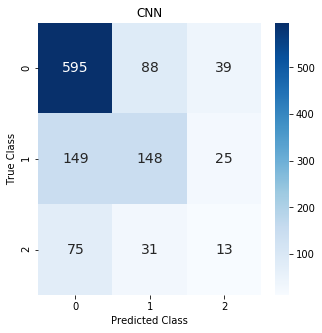

In [0]:
# if sum is (0 or 1) -> 0(predicted class )  else (2 , 3) -> 1
# final_prediction = np.sum(np.array(test_predictions).T , axis = 1)//2
from scipy import stats

final_prediction = stats.mode(np.array(test_predictions).T,axis=1)[0].flatten()

# print(set(final_prediction))
print(classification_report(Y_test , final_prediction))
results = confusion_matrix(Y_test , final_prediction)

%matplotlib inline
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('CNN')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [103]:
f1_score(Y_test, final_prediction, average='micro')  

0.648323301805675

### Misclassified examples for k fold

In [0]:
y_test_predict_cat = final_prediction
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict_cat)

In [95]:
print(set(y_test))
print(set(y_test_predict_cat))

{0, 1, 2}
{0, 1, 2}


In [0]:
X_test.iloc[0,0]

'@USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER now you touched visa-mata\'s raw nerve by saying modi for 2019" thats why she may block you soon  she is having wild/wet dream of being PM after modi fail to get full majority in 2019.  please dont wake her up from her dream of bhajpaa getting 160 seat in 2014"'

In [0]:
def prRed(skk): print("\033[91m {}\033[00m" .format(skk)) 
def prGreen(skk): print("\033[92m {}\033[00m" .format(skk)) 
def prPurple(skk): print("\033[95m {}\033[00m" .format(skk)) 
def prCyan(skk): print("\033[96m {}\033[00m" .format(skk)) 
def prLighBlue(skk): print("\033[94m {}\033[00m" .format(skk)) 
def prOrange(skk): print("\033[33m {}\033[00m" .format(skk)) 

Red: original individual insult (0), classified as group (1)<br>
Green: original individual insult (0), classified as other (2)<br>
Purple: original group insult (1), classified as individual (0) <br>
Cyan: original group insult (1), classified as other (2)<br>
Light Blue: original other insult (2), classified as individual (0) <br>
Orange: original other insult (2), classified as group (1)

In [0]:
def print_stuff(idx):
  global test_predictions
  global X_test
  global y_test
  # preprocessed_tweet
  print('preprocessed tweet')
  print(X_test.iloc[idx,1])
  # computed prob
  print('computed classes: ',np.array(test_predictions).T[idx])
  print('original class: ',y_test[idx] )

In [101]:
#IND=0, GRP=1 , OTH= 2
c = [0] * 6
limit = 5
for index in misclassified[0]:
  #original individual insult (0), classified as group (1)
  if limit in c:
    break
  if y_test[index] == 0 and y_test_predict_cat[index] == 1:
    prRed(X_test.iloc[index,0])
    print_stuff(index)
    c[0] += 1
  #original individual insult (0), classified as other (2)
  elif y_test[index] == 0 and y_test_predict_cat[index] == 2:
    prGreen(X_test.iloc[index,0])
    print_stuff(index)
    c[1] += 1
  #original group insult (1), classified as individual (0)
  elif y_test[index] == 1 and y_test_predict_cat[index] == 0:
    prPurple(X_test.iloc[index,0])
    print_stuff(index)
    c[2] += 1
  #original group insult (1), classified as other (2)
  elif y_test[index] == 1 and y_test_predict_cat[index] == 2:
    prCyan(X_test.iloc[index,0])
    print_stuff(index)
    c[3] += 1
  #original other insult (2), classified as individual (0)
  elif y_test[index] == 2 and y_test_predict_cat[index] == 0:
    prLighBlue(X_test.iloc[index,0])
    print_stuff(index)
    c[4] += 1
  #original other insult (2), classified as group (1)
  elif y_test[index] == 2 and y_test_predict_cat[index] == 1:
    prOrange(X_test.iloc[index,0])
    print_stuff(index)
    c[5] += 1


 @USER //xD Well the suffering she goes through and all the terrible shit she sees ends up making her pretty insane (I think you already seen that from certain things I posted XD) but hey at least she's only insane to bad guys!
preprocessed tweet
xd well suffer go terrible shit see end make pretty insane i think already see certain things post xd hey least insane bad guy
computed classes:  [1 0 0]
original class:  1
 @USER @USER @USER Oh and higher unemployment and witch hunts and lynch mobs and antifa communist parades ...you can have all that shit and let Hollywood decide how you feel.
preprocessed tweet
oh higher unemployment witch hunt lynch mob antifa communist parade you shit let hollywood decide feel
computed classes:  [0 0 1]
original class:  2
 @USER thanks Joe!!! my sanity was forsaken a looong time ago hahaha
preprocessed tweet
thank joe sanity forsake looong time ago hahaha
computed classes:  [0 0 2]
original class:  1
 @USER Yes! The good old days when conservatives got pu

## Fit on X_train_bow without cross fold

In [0]:
model = create_model(filter_kernels, dense_outputs, maxlen, vocab_size, nb_filter, cat_output)
model.fit( X_train_bow , Y_train_cat , class_weight=  class_weight, batch_size=batch_size, epochs=nb_epoch, validation_split=0.2)

inputs shape:  (?, 1204)
conv shape:  (?, 1198, 32)
conv max pool shape:  (?, 599, 32)
conv1 shape:  (?, 595, 32)
conv2 shape:  (?, 593, 32)
conv3 shape:  (?, 592, 32)
conv4 shape:  (?, 591, 32)
conv5 shape:  (?, 590, 32)
conv5 m.p shape:  (?, 295, 32)
conv5 flatten shape:  (?, ?)
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1204)              0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 1204, 69)          0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 1198, 32)          15488     
_________________________________________________________________
MaxPool1 (MaxPooling1D)      (None, 599, 32)           0         
_________________________________________________________________
Conv2 (Conv1D)               (None, 595, 

Predicting on X_test_bow

In [0]:
y_test_predict = model.predict(X_test_bow)
y_test_predict_cat = y_test_predict.argmax(axis = 1)

              precision    recall  f1-score   support

           0       0.72      0.67      0.69       722
           1       0.47      0.45      0.46       322
           2       0.11      0.18      0.14       119

    accuracy                           0.56      1163
   macro avg       0.43      0.43      0.43      1163
weighted avg       0.59      0.56      0.57      1163



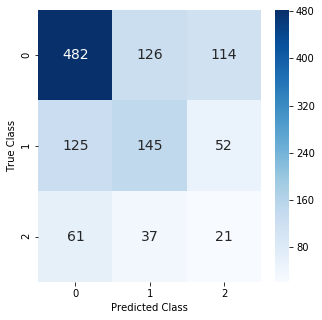

In [0]:
print(classification_report(Y_test , y_test_predict_cat))
results = confusion_matrix(Y_test , y_test_predict_cat)

%matplotlib inline
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [0]:
f1_score(Y_test, final_prediction, average='macro')  

0.4691418593044034

### Misclassified examples for without k fold

In [0]:
y_test_predict_cat = final_prediction
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict_cat)

Red: original individual insult (0), classified as group (1)<br>
Green: original individual insult (0), classified as other (2)<br>
Purple: original group insult (1), classified as individual (0) <br>
Cyan: original group insult (1), classified as other (2)<br>
Light Blue: original other insult (2), classified as individual (0) <br>
Orange: original other insult (2), classified as group (1)

In [102]:
#IND=0, GRP=1 , OTH= 2
c = [0] * 6
limit = 5
for index in misclassified[0]:
  #original individual insult (0), classified as group (1)
  if limit in c:
    break
  if y_test[index] == 0 and y_test_predict_cat[index] == 1:
    prRed(X_test.iloc[index,0])
    print_stuff(index)
    c[0] += 1
  #original individual insult (0), classified as other (2)
  elif y_test[index] == 0 and y_test_predict_cat[index] == 2:
    prGreen(X_test.iloc[index,0])
    print_stuff(index)
    c[1] += 1
  #original group insult (1), classified as individual (0)
  elif y_test[index] == 1 and y_test_predict_cat[index] == 0:
    prPurple(X_test.iloc[index,0])
    print_stuff(index)
    c[2] += 1
  #original group insult (1), classified as other (2)
  elif y_test[index] == 1 and y_test_predict_cat[index] == 2:
    prCyan(X_test.iloc[index,0])
    print_stuff(index)
    c[3] += 1
  #original other insult (2), classified as individual (0)
  elif y_test[index] == 2 and y_test_predict_cat[index] == 0:
    prLighBlue(X_test.iloc[index,0])
    print_stuff(index)
    c[4] += 1
  #original other insult (2), classified as group (1)
  elif y_test[index] == 2 and y_test_predict_cat[index] == 1:
    prOrange(X_test.iloc[index,0])
    print_stuff(index)
    c[5] += 1


 @USER //xD Well the suffering she goes through and all the terrible shit she sees ends up making her pretty insane (I think you already seen that from certain things I posted XD) but hey at least she's only insane to bad guys!
preprocessed tweet
xd well suffer go terrible shit see end make pretty insane i think already see certain things post xd hey least insane bad guy
computed classes:  [1 0 0]
original class:  1
 @USER @USER @USER Oh and higher unemployment and witch hunts and lynch mobs and antifa communist parades ...you can have all that shit and let Hollywood decide how you feel.
preprocessed tweet
oh higher unemployment witch hunt lynch mob antifa communist parade you shit let hollywood decide feel
computed classes:  [0 0 1]
original class:  2
 @USER thanks Joe!!! my sanity was forsaken a looong time ago hahaha
preprocessed tweet
thank joe sanity forsake looong time ago hahaha
computed classes:  [0 0 2]
original class:  1
 @USER Yes! The good old days when conservatives got pu

In [0]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open(root_path + "/CNN/model_C.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights(root_path + "/CNN/model_C.h5")
print("Saved model to disk")

Saved model to disk
